In [1]:
import pandas as pd
import numpy as np
import joblib
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from skopt import gp_minimize, space
from pandas import Timestamp
from functools import partial
from hyperopt import hp, fmin, tpe, Trials
from hyperopt.pyll.base import scope
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def preprocessing_own(df):
    if df.isnull().values.any():
        df.fillna(method='ffill', inplace=True)
    df['hour_of_day'] = [datetime.fromisoformat(n).hour for n in df['created_at']]
    df['s2_pm2_5'] = train_set['s2_pm2_5'].mask(df['s2_pm2_5']==0).fillna(df['pm2_5'])
    df['s2_pm10'] = train_set['s2_pm10'].mask(df['s2_pm10']==0).fillna(df['pm10'])
    df.drop(columns=['site', 'created_at', 'landform_90m', 'dist_major_road'], axis=1, inplace=True)
    return df

In [3]:
train_set = pd.read_csv('../input/train_set.csv')
train_set.head()

,created_at,site,pm2_5,pm10,s2_pm2_5,s2_pm10,humidity,temp,lat,long,altitude,greenness,landform_90m,landform_270m,population,dist_major_road,ref_pm2_5
0,2019-12-02 08:00:00+03:00,USEmbassy,74.088667,83.767111,0.000000,0.000000,0.962917,21.475000,0.299255,32.592686,1199,4374,21,14,6834,130,95.0
1,2020-03-17 02:00:00+03:00,USEmbassy,88.350233,96.003023,86.993256,107.929767,0.967667,19.233333,0.299255,32.592686,1199,4374,21,14,6834,130,139.0
2,2019-10-13 05:00:00+03:00,USEmbassy,47.540513,58.672308,48.684103,60.505128,0.999250,18.916667,0.299255,32.592686,1199,4374,21,14,6834,130,46.0
3,2020-04-04 11:00:00+03:00,USEmbassy,24.567619,27.151429,23.406667,27.316429,0.783500,25.475000,0.299255,32.592686,1199,4374,21,14,6834,130,33.0
4,2020-03-22 20:00:00+03:00,USEmbassy,46.644857,57.555143,46.195143,60.075714,0.721833,22.916667,0.299255,32.592686,1199,4374,21,14,6834,130,60.0


In [4]:
train_set = preprocessing_own(train_set)
train_set.head()

,pm2_5,pm10,s2_pm2_5,s2_pm10,humidity,temp,lat,long,altitude,greenness,landform_270m,population,ref_pm2_5,hour_of_day
0,74.088667,83.767111,74.088667,83.767111,0.962917,21.475000,0.299255,32.592686,1199,4374,14,6834,95.0,8
1,88.350233,96.003023,86.993256,107.929767,0.967667,19.233333,0.299255,32.592686,1199,4374,14,6834,139.0,2
2,47.540513,58.672308,48.684103,60.505128,0.999250,18.916667,0.299255,32.592686,1199,4374,14,6834,46.0,5
3,24.567619,27.151429,23.406667,27.316429,0.783500,25.475000,0.299255,32.592686,1199,4374,14,6834,33.0,11
4,46.644857,57.555143,46.195143,60.075714,0.721833,22.916667,0.299255,32.592686,1199,4374,14,6834,60.0,20


In [6]:
X = train_set.drop(columns = ['ref_pm2_5'], axis=1)
y = train_set['ref_pm2_5']

In [7]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.45, random_state=42)

In [32]:
rfr = RandomForestRegressor()
rfr.fit(Xtrain, ytrain)
ypred = rfr.predict(Xtest)
rmse = round(mean_squared_error(ytest, ypred, squared=False), 2)
rmse

13.34

#### Hyperopt

In [33]:
space = {
    'n_estimators':scope.int(hp.quniform('n_estimators', 100, 500, 1)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 30, 1)),
    'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 20, 1)),
    'min_samples_split':scope.int(hp.quniform('min_samples_split', 1, 100, 1)),
    'max_features': hp.choice('max_features', ['log2', 'sqrt', 'auto']),
    'oob_score': hp.choice('oob_score', [True, False])
    
}

In [34]:
def optimize(params):
    model = RandomForestRegressor(**params)
    model.fit(Xtrain, ytrain)
    ypred = model.predict(Xtest)
    rmse = mean_squared_error(ytest, ypred, squared=False)
    return -1*rmse

In [35]:
optimization_function = partial(optimize)

In [36]:
trials = Trials()

In [37]:
best = fmin(
    fn=optimization_function,
    space=space,
    algo=tpe.suggest,
    max_evals=15,
    trials=trials)

100%|███████████████████████████████████████████████| 15/15 [00:26<00:00,  1.74s/trial, best loss: -24.478951695471903]


In [38]:
best

{'max_depth': 1.0,
 'max_features': 1,
 'min_samples_leaf': 4.0,
 'min_samples_split': 54.0,
 'n_estimators': 396.0,
 'oob_score': 1}

In [40]:
rfr = RandomForestRegressor(max_depth= 1,
                            max_features= 1,
                            min_samples_leaf= 4,
                            min_samples_split= 54,
                            n_estimators= 396,
                            oob_score= True).fit(Xtrain, ytrain)
ypred = rfr.predict(Xtest)
rmse = round(mean_squared_error(ytest, ypred, squared=False), 2)
rmse

28.75

#### Randomized Search

In [42]:
param_grid = {
    'n_estimators': [100, 150, 200, 250, 300, 350, 400, 500],
    'max_depth': [1, 5, 8, 15, 25, 30],
    'max_features': ['log2', 'sqrt', 'auto'],
    'min_samples_leaf': [1, 2, 4, 5, 8, 10],
    'min_samples_split': [1, 2, 5, 10, 15, 50, 100],
    'oob_score':[True, False]
}

In [43]:
rf = RandomForestRegressor()

In [47]:
model = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    scoring='neg_root_mean_squared_error',
    verbose=1,
    n_jobs=-1,
    cv=5,
    n_iter=100
)

In [48]:
model.fit(Xtrain, ytrain)
print(f'Best score: {model.best_score_}')
print('Best parameters set:')
best_parameters = model.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print(f"\t{param_name}: {best_parameters[param_name]}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits


c:\users\user\anaconda3\envs\ox\lib\site-packages\sklearn\model_selection\_search.py:921: UserWarning: One or more of the test scores are non-finite: [-16.77198119 -15.73329412 -15.26495921          nan -15.68371061
 -25.7986933           nan -15.99921369 -16.16160441 -26.68493968
 -15.91696804          nan -16.04988915 -15.5561812  -16.09826962
          nan          nan -15.74033625 -15.55985949          nan
          nan -15.73184485 -16.06979456 -17.01349817 -15.92133002
 -26.64117784 -15.77607854 -16.18466438          nan -15.90344085
 -16.22625361 -15.70439781 -15.58060059 -15.29252085 -15.97170619
          nan -16.45169746 -16.85127704 -15.7888151  -15.58981632
 -15.51680603 -15.68339945 -15.86403796 -16.8048331  -16.15611567
 -17.03432873 -16.3510734  -25.78745735 -15.91840591 -15.44241963
 -26.57172205 -15.49899655 -16.83123505 -15.78828973          nan
 -16.84516918 -26.64660668 -16.43085341 -15.49018672 -15.98721164
 -16.60741636 -16.31765156 -15.77581503 -16.10277307 -16.0

Best score: -15.264959206149843
Best parameters set:
	max_depth: 15
	max_features: auto
	min_samples_leaf: 2
	min_samples_split: 2
	n_estimators: 100
	oob_score: False


In [49]:
rf = RandomForestRegressor(
    max_depth=15,
    max_features='auto',
    min_samples_leaf=2,
    min_samples_split=2,
    n_estimators=100,
    oob_score=False).fit(Xtrain, ytrain)

In [52]:
ypred = rf.predict(Xtest)
rmse = round(mean_squared_error(ytest, ypred, squared=False), 2)
rmse

13.22

#### GridSearchCV

In [53]:
param_grid = {
    'n_estimators': [100, 150, 200, 250, 300, 350],
    'max_depth': [10, 15, 20, 25, 30],
    'max_features': ['sqrt', 'auto'],
    'min_samples_leaf': [2, 4, 8, 10],
    'min_samples_split': [2, 5, 10, 15, 50],
    'oob_score':[True, False]
}

In [55]:
rf = RandomForestRegressor()

In [56]:
model = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    verbose=1,
    n_jobs=-1,
    cv=5,
)

In [57]:
model.fit(Xtrain, ytrain)
print(f'Best score: {model.best_score_}')
print('Best parameters set:')
best_parameters = model.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print(f"\t{param_name}: {best_parameters[param_name]}")

Fitting 5 folds for each of 2400 candidates, totalling 12000 fits
Best score: -15.271616735429527
Best parameters set:
	max_depth: 20
	max_features: auto
	min_samples_leaf: 2
	min_samples_split: 2
	n_estimators: 200
	oob_score: False


In [58]:
rf = RandomForestRegressor(
    max_depth=20,
    max_features='auto',
    min_samples_leaf=2,
    min_samples_split=2,
    n_estimators=200,
    oob_score=False).fit(Xtrain, ytrain)

In [59]:
ypred = rf.predict(Xtest)
rmse = round(mean_squared_error(ytest, ypred, squared=False), 2)
rmse

13.19

In [20]:
#joblib.dump(rfr, 'random_forest_final.joblib')

In [23]:
rfr = joblib.load('random_forest_final.joblib')

In [24]:
rfr = RandomForestRegressor().fit(Xtrain, ytrain)
ypred = rfr.predict(Xtest)
rmse = round(mean_squared_error(ytest, ypred, squared=False), 2)
rmse

13.33

#### Testing on held-out data

In [26]:
Xactual = pd.read_csv('../input/test_set.csv')
Xactual = preprocessing_own(Xactual)
Xactual.head()

,pm2_5,pm10,s2_pm2_5,s2_pm10,humidity,temp,lat,long,altitude,greenness,landform_270m,population,hour_of_day
0,9.903636,10.259545,74.088667,83.767111,0.748000,26.491667,0.299255,32.592686,1199,4374,14,6834,12
1,38.428333,45.940714,86.993256,107.929767,0.995000,18.225000,0.299255,32.592686,1199,4374,14,6834,6
2,13.278000,14.967333,13.278000,14.967333,0.687500,24.891667,0.299255,32.592686,1199,4374,14,6834,17
3,36.304000,40.366750,23.406667,27.316429,0.868417,22.616667,0.299255,32.592686,1199,4374,14,6834,9
4,56.686410,67.412308,46.195143,60.075714,0.782083,23.350000,0.299255,32.592686,1199,4374,14,6834,19


In [27]:
yactual = pd.read_csv('../input/test_solution.csv')
yactual.head()

,ref_pm2_5
0,30.0
1,44.0
2,27.0
3,48.0
4,57.0


In [28]:
ypred = rfr.predict(Xactual)
rmse = round(mean_squared_error(yactual, ypred, squared=False), 2)
rmse

20.51

In [30]:
yactual.shape, ypred.shape

((2733, 1), (2733,))

In [34]:
ypred= ypred.reshape(2733, 1)
ypred.shape

(2733, 1)

Text(0, 0.5, 'Predictions ')

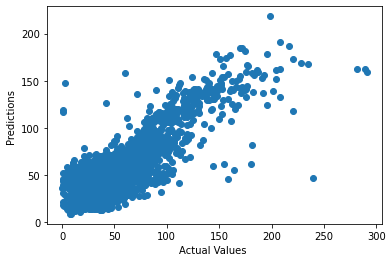

In [36]:
g=plt.scatter(yactual, ypred)
g.axes.set_xlabel('Actual Values ')
g.axes.set_ylabel('Predictions ')